# CIFAR10 Image Classification Using LeNet

In this tutorial, we are going to walk through the logic in `lenet_cifar10_mixup.py` shown below and provide step-by-step instructions.

In [ ]:
!cat lenet_cifar10_mixup.py

## Step 1: Prepare training and evaluation dataset, create FastEstimator `Pipeline`

`Pipeline` can take both data in memory and data in disk. In this example, we are going to use data in memory by loading data with `tf.keras.datasets.cifar10`

In [2]:
import tensorflow as tf

(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.cifar10.load_data()
print("train image shape is {}".format(x_train.shape))
print("train label shape is {}".format(y_train.shape))
print("eval image shape is {}".format(x_eval.shape))
print("eval label shape is {}".format(y_eval.shape))

train image shape is (50000, 32, 32, 3)
train label shape is (50000, 1)
eval image shape is (10000, 32, 32, 3)
eval label shape is (10000, 1)


For in-memory data in `Pipeline`, the data format should be a nested dictionary like: {"mode1": {"feature1": numpy_array, "feature2": numpy_array, ...}, ...}. Each `mode` can be either `train` or `eval`, in our case, we have both `train` and `eval`.  `feature` is the feature name, in our case, we have `x` and `y`.

In [3]:
data = {"train": {"x": x_train, "y": y_train}, "eval": {"x": x_eval, "y": y_eval}}

In [ ]:
#Parameters
epochs = 35
batch_size = 50
steps_per_epoch = None
validation_steps = None

Now we are ready to define `Pipeline`, we want to apply a `Minmax` online preprocessing to the image feature `x` for both training and evaluation:

In [4]:
import fastestimator as fe
from fastestimator.op.tensorop import Minmax

pipeline = fe.Pipeline(batch_size=batch_size, data=data, ops=Minmax(inputs="x", outputs="x"))

## Step 2: Prepare model, create FastEstimator `Network`

First, we have to define the network architecture in `tf.keras.Model` or `tf.keras.Sequential`, for a popular architecture like LeNet, FastEstimator has it implemented already in [fastestimator.architecture.lenet](https://github.com/fastestimator/fastestimator/blob/master/fastestimator/architecture/lenet.py).  After defining the architecture, users are expected to feed the architecture definition and its associated model name, optimizer and loss name (default to be 'loss') to `FEModel`.

In [5]:
from fastestimator.architecture import LeNet

model = fe.build(model_def=lambda: LeNet(input_shape=x_train.shape[1:], 
                 classes=10), model_name="LeNet", 
                 optimizer="adam", 
                 loss_name="loss")

We can now define a simple `Network`: given with a batch data with key `x` and `y`, we have to work our way to `loss` with series of operators.  `ModelOp` is an operator that contains a model.

In [6]:
from fastestimator.op.tensorop import ModelOp, SparseCategoricalCrossentropy

simple_network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                                 SparseCategoricalCrossentropy(y_pred="y_pred", y_true="y", outputs="loss")])

One advantage of `FastEstimator`, though, is that it is easy to construct much more complicated graphs. In this example, we want to conduct training by [mixing up input images](https://arxiv.org/abs/1710.09412), since this has been shown to make neural networks more robust against adversarial attacks, as well as helping to prevent over-fitting. To achieve this in `FastEstimator`, we start by randomly pairing and linearly combining inputs, then feeding the mixed images to the `ModelOp` before computing the loss. Note that mixup is only performed during training (not evaluation), and so the mode on the mix-related operations is set to 'train'. We use schedulers to enable mixup only after the first epoch, since it takes quite a while to converge otherwise.

In [7]:
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy as KerasCrossentropy
from fastestimator.op.tensorop import MixUpBatch, MixUpLoss
from fastestimator.schedule import Scheduler

pipeline2 = fe.Pipeline(batch_size=batch_size, data=data, ops=Minmax(inputs="x", outputs="x"))
model2 = fe.build(model_def=lambda: LeNet(input_shape=x_train.shape[1:], classes=10), model_name="LeNet", 
                  optimizer="adam", loss_name="loss")
warmup = 1

mixup_network = fe.Network(ops=[
        Scheduler({warmup: MixUpBatch(inputs="x", outputs=["x", "lambda"], alpha=1, mode="train")}),
        ModelOp(inputs="x", model=model2, outputs="y_pred"),
        Scheduler({0: SparseCategoricalCrossentropy(y_true="y", y_pred="y_pred", mode="train", outputs="loss"),
                   warmup: MixUpLoss(KerasCrossentropy(), lam="lambda", y_true="y", y_pred="y_pred", mode="train", outputs="loss")}),
        SparseCategoricalCrossentropy(y_true="y", y_pred="y_pred", mode="eval", outputs="loss")
    ])

## Step 3: Configure training, create `Estimator`

During the training loop, we want to: 1) measure accuracy for data data 2) save the model with lowest valdiation loss. The `Trace` class is used for anything related to the training loop, and we will need to import the `Accuracy` and `ModelSaver` traces.

In [8]:
import tempfile
import os
from fastestimator.trace import Accuracy, ModelSaver

simple_traces = [Accuracy(true_key="y", pred_key="y_pred", output_name='acc')]

mixup_traces = [Accuracy(true_key="y", pred_key="y_pred", output_name='acc')]

Now we can define the `Estimator` and specify the training configuation. We will create estimators for both the simple and adversarial networks in order to compare their performances.

In [9]:
simple_estimator = fe.Estimator(network=simple_network, 
                                pipeline=pipeline, 
                                epochs=epochs, 
                                steps_per_epoch=steps_per_epoch,
                                validation_steps=validation_steps,
                                traces=simple_traces, 
                                log_steps=750)

mixup_estimator = fe.Estimator(network=mixup_network, 
                               pipeline=pipeline2, 
                               epochs=epochs, 
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=validation_steps,
                               traces=mixup_traces, 
                               log_steps=750)

## Step 4: Training

We'll start by training the regular network (takes about 20 minutes on a 2015 MacBookPro CPU - 2.5 GHz Intel Core i7). The network should attain a peak evaluation accuracy around 72%

In [ ]:
simple_summary = simple_estimator.fit(summary="simple")

Next we train the network using mixup. This process requires more epochs to converge since the training process is more difficult, though should get to around 75% evaluation accuracy.

In [ ]:
mixup_summary = mixup_estimator.fit(summary="mixup")

## Step 5: Comparing Results

As the performance logs make clear, the mixup training method is extremely effective in combatting overfitting. Whereas the regular model begins to overfit around epoch 7, the network with mixup training continues to improve even after 35 epochs.

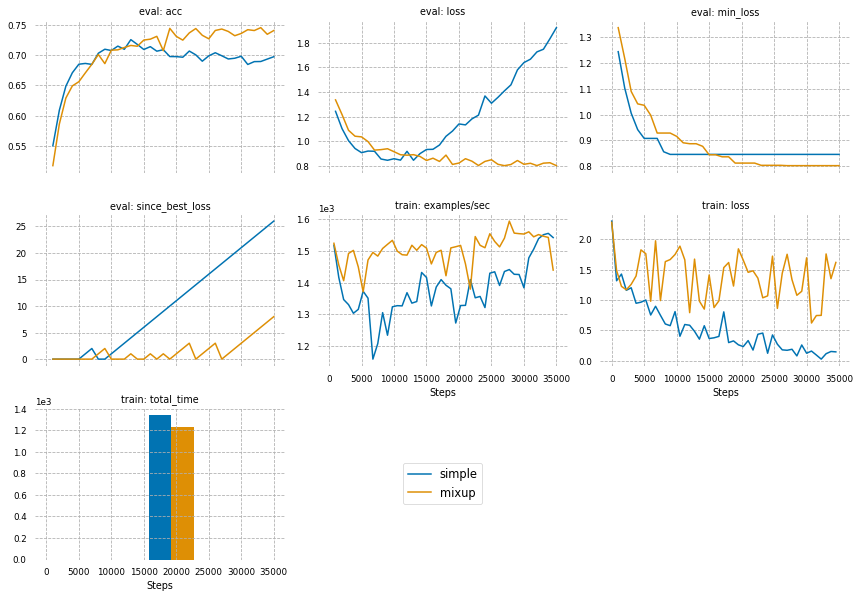

In [12]:
from fastestimator.summary import visualize_logs

visualize_logs([simple_summary, mixup_summary], ignore_metrics={"LeNet_lr"})